In [13]:
using Zygote, Flux, Statistics, Plots, Distributions, LinearAlgebra, ProgressBars, IJulia
using Flux.Optimise: update!

num_particles = 2
harmonic_omega = 1.0
omega = 1
g = 0
sigma = -g/2
C = 2

# make the model
model = f64(Chain(
	Dense(num_particles => 50, bias=true, celu; init=Flux.ones32),
    Dense(50 => 1, bias=true; init=Flux.ones32)
))


paramCount = 0
for layer in model
    paramCount += sum(length, Flux.params(layer))
end
println("Number of parameters: ", paramCount)


transform(coord) = [sum(coord ./ C).^(i+1) for i in eachindex(coord)] 
A(coords) = model(transform(coords))[1] + omega * sum(coords.^2)
psi(coords) = exp(-A(coords))
psi_sq(coords) = psi(coords).^2

# derivative of A wrt the coordinates
dA_dx(coords) = gradient(A,coords)[1]

# take the gradient of A wrt the parameters of the network, which are not passed in as arguments, but are global
#TODO: theres something wrong with this gradient, it gives the wrong answer for the biases
dA_dtheta(coords) = gradient(() -> A(coords), Flux.params(model))



# second derivative of A wrt the coordinates
d2A_dx2(coords) = diaghessian(A, coords)[1]

function sample(distribution,  num_particles, num_samples, num_thermalization, num_skip, variation)
    # start by computing the total number of steps that we will take
    total_steps = num_samples * num_skip + num_thermalization
    # number of accepted steps
    num_accepted = 0
    # create a vector of outputs of length num_samples
	samples = Array{Float64}(undef, 0, num_particles)

    # pick a starting point
    x = zeros(num_particles) 
    for step in 1:total_steps 
        # propose a new point
        rand_shift = rand(Uniform(-variation, variation), num_particles)

		x_prime = x + rand_shift
        # generate a random number between 0 and 1
		r = rand(Uniform(0,1))
        if r < distribution(x_prime)/distribution(x)
            # accept the new point
            x = x_prime
            num_accepted += 1
        end

        # now check whether it is time to record a sample
        if step > num_thermalization && mod(step, num_skip) == 0
            # record the sample
            samples = [samples; x']
        end
    end

    # for every sample in samples, replace the second value with a copy of the first value
    samples_prime = copy(samples)
    for i in 1:num_samples
        samples_prime[i, 2] = samples[i, 1]
    end

    return samples, samples_prime, (num_accepted/total_steps) 
end

# define the energy computation
function Hpsi(coords, coords_prime, alpha)
    return Hpwd(coords)  .+ delta_pot(coords, coords_prime, alpha) 
end

function sigma_term(coords)
    sigma_term = 0
    for i in 1:num_particles
        for j in i:num_particles
            sigma_term += sigma * abs(coords[i]-coords[j])
        end
    end
    return sigma_term
end

function Hpwd(coords)
    return 1/2 .* (sum(d2A_dx2(coords)) .- sum(dA_dx(coords).^2)) + 1/2 .* harmonic_omega^2 .* sum(coords.^2) .+ sigma_term(coords)
end

function delta_pot(coords, coords_prime, alpha)
    ratio = psi_sq(coords_prime)/psi_sq(coords)
    delta_dist = (1/(sqrt(pi) * alpha)) * exp(-(coords[1]^2)/(alpha^2))
    return g * num_particles*(num_particles-1)/2 * ratio * delta_dist
end


function second_term(coords)
    return dA_dtheta(coords) .* Hpwd(coords)
end

function third_term(coords, coords_prime, alpha)
    return dA_dtheta(coords_prime) .* delta_pot(coords, coords_prime, alpha)
end

function gradsum(grads)
    sum = grads[1]
    for g in grads[2:end]
        sum = sum .+ g
    end
    return sum
end

function grad(num_samples=10^3, thermal=1000, skip=200, variation=1.0)
    # get the samples
    samples, samples_prime, _ = sample(psi_sq, num_particles, num_samples, thermal, skip, variation)

    # get the maximum of the x coordinate in the samples
    y_max = maximum(abs.(samples[:, 2]))
    alpha = y_max/(sqrt(-log(sqrt(pi) * 10^(-10))))

    Es = []
    dadthetas = []
    seconds = []
    thirds = []
    # now iterate through the samples
    for i in 1:num_samples
        # get the current sample
        coords = samples[i, :]
        coords_prime = samples_prime[i, :]
        
        # append Hpsi to Es
        push!(Es, Hpsi(coords, coords_prime, alpha))
        push!(dadthetas, dA_dtheta(coords))
        push!(seconds, second_term(coords))
        push!(thirds, third_term(coords, coords_prime, alpha))
    end
    # compute the average of Es
    E_avg = 1/num_samples * sum(Es)
    dadtheta_avg = 1/num_samples .* gradsum(dadthetas)
    seconds_avg = 1/num_samples .* gradsum(seconds)
    thirds_avg = 1/num_samples .* gradsum(thirds)
    # @show E_avg
    # @show dadtheta_avg[Flux.params(model)[1]]
    # @show dadtheta_avg[Flux.params(model)[2]]
    # @show dadtheta_avg[Flux.params(model)[3]]
    # @show dadtheta_avg[Flux.params(model)[4]]
    # @show seconds_avg[Flux.params(model)[4]]
    uncert = std(Es)/sqrt(num_samples)

    g = 2 * E_avg .* dadtheta_avg .- 2 .* seconds_avg  .- 2 .* thirds_avg
    return g, E_avg, uncert
end

function train(initial_params, iterations, num_samples, learning_rate, variation)
    opt = ADAM(learning_rate)  # Ensure to set the learning rate
    # set the model parameters 
    Flux.loadparams!(model, initial_params)
    # arrays to store the energies and uncertainties
    energies = []
    uncerts = []

    # now train
    iter =  ProgressBars.tqdm(1:iterations) 
    for step in iter
        # compute the gradient 
        g, energy, uncert =  grad(num_samples, 1000, 200, variation)
        # append the energy and uncert
        push!(energies, energy)
        push!(uncerts, uncert)
        set_description(iter , string(energy))
        # update the parameters
        for p in Flux.params(model)
            Flux.update!(opt, p, g[p])  # Update parameters in place
        end
        IJulia.clear_output(true)
    end
    return energies, uncerts
end
#TODO: the gradient of the biases is wrong

Number of parameters: 201


train (generic function with 1 method)

In [14]:
Flux.params(model)

Params([[1.0 1.0; 1.0 1.0; … ; 1.0 1.0; 1.0 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0 1.0 … 1.0 1.0], [0.0]])

In [15]:
# println(psi([1,2]))
# println(dA_dx([1,2]))
# println(d2A_dx2([1,2]))
# println(Hpwd([1,2]))
println(grad(10^4, 1000, 200, 1.0)[1][Flux.params(model)[1]])
println(grad(10^4, 1000, 200, 1.0)[1][Flux.params(model)[2]])
println(grad(10^4, 1000, 200, 1.0)[1][Flux.params(model)[3]])
println(grad(10^4, 1000, 200, 1.0)[1][Flux.params(model)[4]])

LoadError: InterruptException:

In [12]:
samples, _, _= sample(psi_sq, num_particles, 10^4, 1000, 100, 1.0)

([-1.2739236812150077 -2.5812759507011647; -2.137820728416899 -1.937752903438832; … ; -1.995274678401989 -1.8040916719414843; -2.586983125713652 -1.486988306201339], [-1.2739236812150077 -1.2739236812150077; -2.137820728416899 -2.137820728416899; … ; -1.995274678401989 -1.995274678401989; -2.586983125713652 -2.586983125713652], 0.18315084915084914)

 18.281322 seconds (148.18 M allocations: 8.742 GiB, 10.46% gc time, 0.37% compilation time)
0.18283958020989505


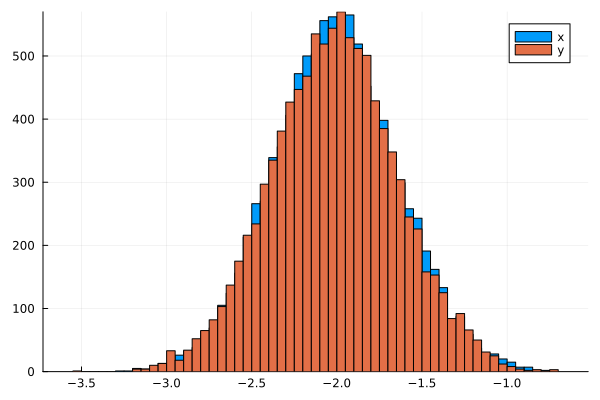

In [10]:
# get samples and print the acceptance rate
@time samples, samples_prime, rate = sample(psi_sq, num_particles, 10^4, 1000, 200, 1)
println(rate)
# get all the x values
xs = samples[:, 1]
# get all the y values
ys = samples[:, 2]
# histogram the x samples
histogram(xs, bins=100, label="x")
# histogram the y samples
histogram!(ys, bins=100, label="y")


In [6]:
res = train(Flux.params(model), 50, 10^3, 10^(-4), 1)

1.8576371620188885 100.0%┣██████████████████████████┫ 50/50 [01:37<00:00, 2s/it]
1.8576371620188885 100.0%┣██████████████████████████┫ 50/50 [01:37<00:00, 2s/it]


(Any[1.8817906971261587, 1.791409249662469, 1.7467039923766179, 1.8879420461029999, 1.9495495770334434, 1.8685983987818, 1.8160877536580207, 1.7482809002652424, 1.786126613522342, 1.8301965307406576  …  1.652297389946183, 1.8802334000612386, 1.7690724182997533, 1.7729648322452287, 1.8782160560022636, 1.7984019871382215, 1.8779148123601617, 1.8735868713027353, 1.8149377778787745, 1.8576371620188885], Any[0.061073484948313765, 0.059869096845794056, 0.06489915094839525, 0.05633012727685301, 0.05061262684484436, 0.05639207493844739, 0.06023405985549086, 0.06427022844725545, 0.061776553060383044, 0.056330862054450585  …  0.07319934160148804, 0.05349106349962591, 0.06312033335419888, 0.060410047938156436, 0.05584712705990636, 0.05544613159974042, 0.05766727880005762, 0.06748024752906406, 0.05884916166610899, 0.053792555725624774])

In [102]:
println(Flux.params(model))

Params([[0.017332026426648876 0.2985727992994523; -1.0200344714903105 -0.8610244564950739; -0.4408869339772136 -1.087963012423672], [-0.04552864143162648, -0.04754125926964819, 0.04859739146039806], [-0.22686751358971116 -0.3729756399136758 0.7370112037513088], [0.0]])


In [43]:
samples, samples_prime, rate = sample(psi_sq, num_particles, 10^3, 1000, 200, 1)
println(rate)

0.2809502487562189


In [44]:
res2 = train(Flux.params(model), 50, 10^3, 10^(-4), 1)

8.992451141409274 100.0%┣███████████████████████████┫ 50/50 [01:37<00:00, 2s/it]
8.992451141409274 100.0%┣███████████████████████████┫ 50/50 [01:37<00:00, 2s/it]


(Any[8.735105802851741, 8.920417501392338, 8.673315463294484, 8.808802957595638, 8.603332844425315, 8.442144454371205, 8.510480127508748, 8.654155799882236, 8.643946737002725, 8.51054596887656  …  8.56271067907028, 8.661317646882418, 8.539538706108734, 8.831859900083057, 8.50630429179867, 8.343736407874129, 8.712970118251357, 8.549518135742677, 8.57478861664427, 8.992451141409274], Any[0.17902658061420756, 0.17545082224059316, 0.2053194544428401, 0.19552650834960972, 0.2141577534571379, 0.19550697083728116, 0.20311653484531042, 0.19400102217486737, 0.22859925683086513, 0.23771103052273349  …  0.21732830135749648, 0.21225685749762652, 0.21053026466219715, 0.22437012557643513, 0.22675195369252032, 0.22322965611370746, 0.1901973119949343, 0.24532342815185965, 0.20687226647347898, 0.18682008615493043])

In [45]:
samples, samples_prime, rate = sample(psi_sq, num_particles, 10^3, 1000, 200, 1)
println(rate)

0.2838258706467662


In [46]:
println(Flux.params(model))

Params([[0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.962600480063575 1.0292780384191194; 0.9

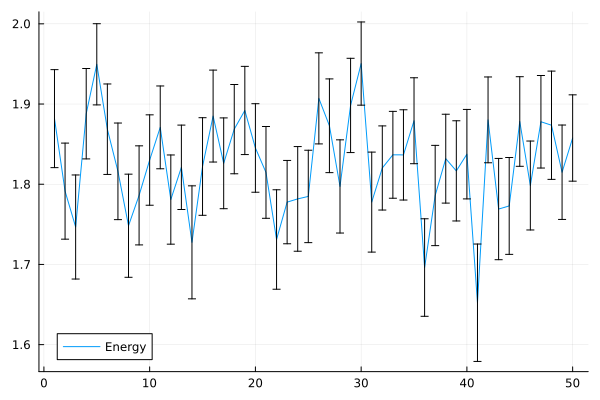

In [7]:
# append the energies and uncerts
# energies = vcat(res[1],res2[1])
# uncerts = vcat(res[2],res2[2])
energies = res[1]
uncerts = res[2]


plot(energies, yerr=uncerts, label="Energy")